# Ejercicio 02 - **viasampling.m**

## Cargando imágen **Bárbara**
Se carga la imágen de **Bárbara** y se la visualiza.

In [25]:
import matplotlib.pyplot as plt

In [1]:
import numpy as np

In [30]:
import PIL

In [89]:
# Read the GIF image from the file system
image_original = PIL.Image.open('../resources/barbara.gif')

In [90]:
# Convert the PIL image into a numpy array
image_original = np.array(image_original)

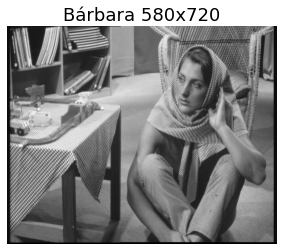

In [91]:
# Plot the image using matplotlib
plt.imshow(image_original, cmap='gray')
plt.title(f'Bárbara {image_original.shape[0]}x{image_original.shape[1]}', fontsize=18)
plt.axis('off')
plt.show()

## Funciones
En esta sección se desarrollan las funciones para realizar el procesamiento.

In [49]:
import cv2

In [60]:
def downsampling(image, factor, filter_on = True):
    """ Downsamples an image by the given factor, with an optional low-pass filtering
        to avoid aliasing when reducing the sampling frequency. This function only supports
        square images.
        @param image Image to be downsampled
        @param factor Downsampling factor
        @param filter_on Whether to apply the decimation filter or not
        @return The downsampled image
    """
    # Get the width and height of the image
    N, M = image.shape
    if N != M:
        raise ValueError('Only square images are supported!')
        
    # Estimate the images spectrum
    spectrum = np.fft.fftshift(np.fft.fft2(image))
    
    # Apply an ideal filter before downsampling the image
    if filter_on:
        for i in range(N):
            for j in range(M):
                distance = (i - np.round(N / 2))**2 + (j - np.round(M / 2))**2
                if (distance > np.round(N / (2 * factor))**2):
                    spectrum[i, j] = 0
    
    # Retrieve the filtered (or not) image in the space domain
    result = np.real(np.fft.ifft2(np.fft.fftshift(spectrum)))
    
    # Downsample the image
    return cv2.resize(result, (N // factor, M // factor), interpolation=cv2.INTER_NEAREST)

In [61]:
def upsampling(image, factor):
    """ Upsamples an image by the given factor.
        @param image Image to be upsampled
        @param factor Upsampling factor
    """
    # Get the width and height of the image
    N, M = image.shape
    if N != M:
        raise ValueError('Only square images are supported!')
    
    # Upsample the image by adding zero samples
    result = np.zeros((N * factor, M * factor))
    for i in range(N):
        for j in range(M):
            result[i * factor, j * factor] = image[i, j]
    
    # Apply an ideal low-pass filter to interpolate the signal to reconstruct
    # the upsampled image, which is needed because zero samples were added
    # when increasing the sampling frequency
    N, M = result.shape
    spectrum = np.fft.fftshift(np.fft.fft2(result))
    for i in range(N):
        for j in range(M):
            distance = (i - np.round(N / 2))**2 + (j - np.round(M / 2))**2
            if (distance > np.round(N / (2 * factor))**2):
                spectrum[i, j] = 0
                
    # Return the image in the space domain
    return (factor**2)*np.abs(np.fft.ifft2(np.fft.fftshift(spectrum)))

## Análisis y experimentos
En esta sección se realizan experimentos con las funciones desarrolladas, para observar los efectos de la teoría de muestreo, aplicando diferentes casos de **downsampling** y **upsampling**.

In [62]:
# Reduce the image to 500x500 size
image_1 = image_original[0:500,0:500]

In [63]:
# Define the downsampling and upsampling factor
factor = 2

### Sin filtrado
Se realiza el downsampling y luego el upsampling, pero sin utilizar un filtrado inicialmente.

In [64]:
# Apply the downsampling without filtering
image_2_not_filtered = downsampling(image_1, factor, filter_on=False)

In [65]:
# Apply the upsampling
image_3_not_filtered = upsampling(image_2_not_filtered, factor)

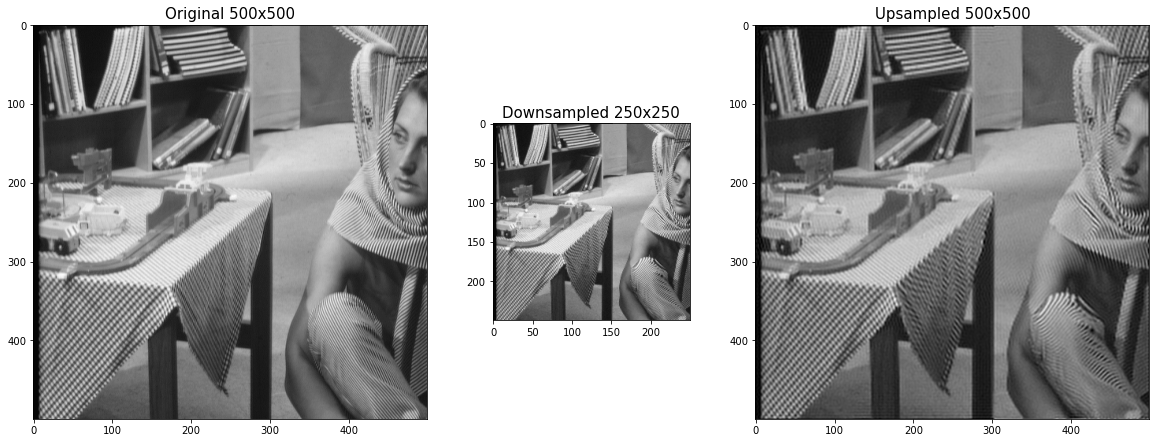

In [85]:
# Create the subplots to layout the images
fig, ax = plt.subplots(1, 3, figsize=(20, 8), gridspec_kw={'width_ratios': [2, 1, 2]})

# Plot the original image
ax[0].set_title(f'Original {image_1.shape[0]}x{image_1.shape[1]}', fontsize=15)
ax[0].imshow(image_1, cmap='gray')

# Plot the downsampled image
ax[1].set_title(f'Downsampled {image_2_not_filtered.shape[0]}x{image_2_not_filtered.shape[1]}', fontsize=15)
ax[1].imshow(image_2_not_filtered, cmap='gray')

# Plot the upsampled image
ax[2].set_title(f'Upsampled {image_3_not_filtered.shape[0]}x{image_3_not_filtered.shape[1]}', fontsize=15)
ax[2].imshow(image_3_not_filtered, cmap='gray')

# Show plots
plt.savefig('../resources/ex2_non_filtered.png')
plt.show()

#### Con filtrado
Se realiza el downsampling y luego el upsampling, utilizado un filtrado inicialmente.

In [74]:
# Apply the downsampling without filtering
image_2_filtered = downsampling(image_1, factor, filter_on=True)

In [77]:
# Apply the upsampling
image_3_filtered = upsampling(image_2_filtered, factor)

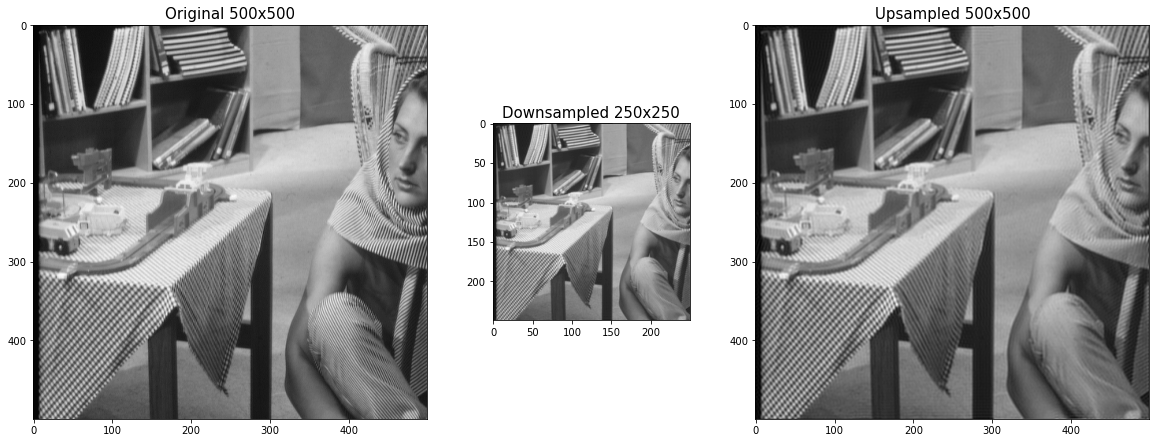

In [84]:
# Create the subplots to layout the images
fig, ax = plt.subplots(1, 3, figsize=(20, 8), gridspec_kw={'width_ratios': [2, 1, 2]})

# Plot the original image
ax[0].set_title(f'Original {image_1.shape[0]}x{image_1.shape[1]}', fontsize=15)
ax[0].imshow(image_1, cmap='gray')

# Plot the downsampled image
ax[1].set_title(f'Downsampled {image_2_filtered.shape[0]}x{image_2_filtered.shape[1]}', fontsize=15)
ax[1].imshow(image_2_filtered, cmap='gray')

# Plot the upsampled image
ax[2].set_title(f'Upsampled {image_3_filtered.shape[0]}x{image_3_filtered.shape[1]}', fontsize=15)
ax[2].imshow(image_3_filtered, cmap='gray')

# Show plots
plt.savefig('../resources/ex2_filtered.png')
plt.show()

## Interpretación
En los escenarios mostrados anteriormente, se tomó una imagen original de un tamaño de 500 píxeles por 500 píxeles que puede ser interpretada como una señal en el dominio discreto (sobre un espacio de dos dimensiones) que es resultado de un muestreo espacial con una frecuencia de muestro espacial desconocida. En ambos escenarios ilustrados, se realizó un **downsampling** con un factor de 2 veces, esto quiere decir que se redujo la frecuencia de muestreo espacial a la mitad. Esta operación consiste en remover la mitad de las muestras de la imagen, y en el dominio de la frecuencia esto provoca que el espectro original de la imagen se vea replicado sobre los múltiplos de la nueva frecuencia de muestreo. Entonces, considerando que la frecuencia se encuentra normalizada y el espectro observado se extiende para $f \in [0, \frac{1}{2}]$. Si se reduce la frecuencia de muestreo a la mitad, por el teorema de Nyquist, para que no ocurra el efecto de **aliasing** es necesario que no haya contenido espectral en $f \in [\frac{1}{4}, \frac{1}{2}]$.

Por lo tanto, como en el primer escenario no se aplica el filtro pasabajos y la señal tiene contenido en $f \in [\frac{1}{4}, \frac{1}{2}]$, entonces el proceso de downsampling provoca que aparezca el efecto del aliasing. Este efecto es la superposición del espectro de la señal que se ve repetido sobre múltiplos de la frecuencia de muestreo, y esa superposición provoca que aparezcan componentes agrupadas que pueden interpretarse matemáticamente como una modulación, y visualmente se pueden observar en las capturas ilustradas a continuación.

<div>
    <img src="../resources/ex2_image_00.png" width="300"/>
    <img src="../resources/ex2_image_01.png" width="314"/>
</div>

**Nota**, más abajo se muestra una estimación del espectro de la imagen original que posee un rectángulo superpuesto para representar el espectro que se estaría observando al reducir la frecuencia de muestreo, así puede observarse claramente la presencia de contenido espectral en zonas por fuera de la región válida. *Esto valida la presencia de aliasing.*

En el segundo escenario, se aplica un filtro pasabajos previo al proceso de downsampling, este filtro ideal remueve el espectro que se encuentra en $f \in [\frac{1}{4}, \frac{1}{2}]$, de esta forma evitar que se produzca el efecto de aliasing, aunque la desventaja es que se pierde información de alta frecuencia de la información original. Esto último se puede evidenciar por el hecho de que ciertas regiones de la imagen han desaparecido, dado que poseían componentes de alta frecuencia que fueron filtradas. No obstante, ya no se observa aliasing en la imagen recuperada. A continuación se muestran capturas de estos detalles mencionados.

<div>
    <img src="../resources/ex2_image_02.png" width="300"/>
    <img src="../resources/ex2_image_03.png" width="406"/>
</div>

Finalmente, en ambos escenarios, luego de realizar el downsampling se realiza la operación de upsampling. Este proceso consiste en aumentar la frecuencia de muestreo de la señal. Para esto, si se quiere aumentar N veces la frecuencia de muestreo, se agregan N-1 muestras nulas entre las muestras preexistentes. Luego, se utiliza un filtro recuperador o interpolador. Desde el punto de vista del dominio espacial, el filtro actúa como un interpolador que obtiene el valor de las muestras intermedias agregadas, y desde el punto de vista del dominio de la frecuencia, se está filtrando el espectro de banda base de la señal original (removiendo las repeticiones en múltiplos de la frecuencia original de muestreo). Es de interés notar que, el proceso de **upsampling** no puede agregar información que no se encontraba originalmente en la imagen, si la imagen poseía aliasing o perdió contenido de alta frecuencia por el filtro de la decimación, entonces eso mismo será observado en el espectro luego del upsampling.

In [142]:
# Calculate the spectrum
spectrum = np.fft.fftshift(np.fft.fft2(image_original))

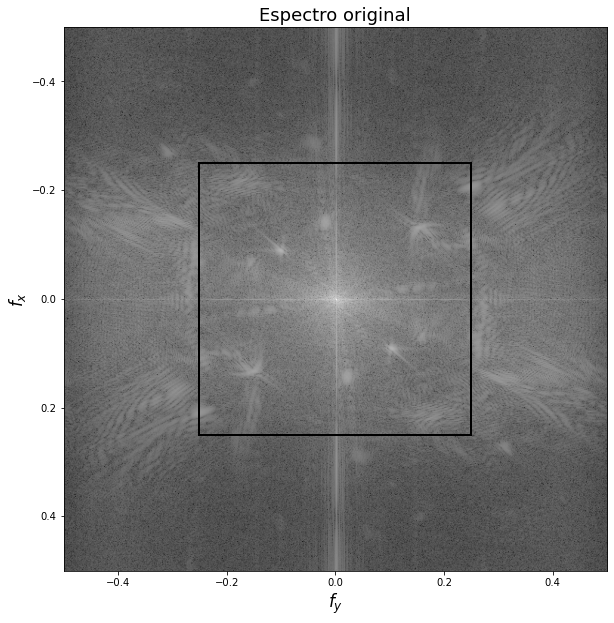

In [143]:
# Create the figure and subplots to layout the spectrum
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)

# Plot the spectrum
ax.imshow(np.log10(np.abs(spectrum)), cmap='gray', extent=[-1/2, 1/2, 1/2, -1/2])

# Plot the rectangle 
rect = plt.Rectangle((-1/4, -1/4), 1/2, 1/2, color='k', fill=False, linewidth=2)
ax.add_patch(rect)

# Configure and show
ax.set_title('Espectro original', fontsize=18)
ax.set_xlabel('$f_y$', fontsize=17)
ax.set_ylabel('$f_x$', fontsize=17)
plt.show()